# Smart Mobility
## Etapa 1 - Rankeamento de Vias

### Cálculos realizados com dados referentes ao período de 01/20/2017 a 21/10/2018, das 07:00 às 09:00 e das 17:00 às 19:00.

In [1]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.geometry import Point

from src.data.processing_func import (connect_database, extract_geo_sections)

import folium

pd.options.display.max_columns = 30

### Carregamento dos dados do Waze:

In [2]:
gdf = gpd.read_file(project_dir + "/data/interim/traffic_indicators.geoJSON")
gdf.dropna(subset=["Rua"], inplace=True)
gdf["Codigo do Trecho"] = gdf["Codigo do Trecho"].astype(int)

#Lookup to change period for Período
lkp_period = pd.DataFrame({"Período": ["Manha", "Tarde"]}, index=[-1, 1])
gdf = gdf.join(lkp_period, on="period")
gdf.drop("period", axis=1, inplace=True)
cols = gdf.columns.tolist()
gdf = gdf[cols[:4] + [cols[-1]] + cols[4:-1]]

#Lookup to translate N/S, W/E directions
lkp_direction_NS = pd.DataFrame({"Sentido N/S": ["Norte", "Sul"]}, index=["North", "South"])
lkp_direction_LO = pd.DataFrame({"Sentido L/O": ["Leste", "Oeste"]}, index=["East", "West"])
gdf = gdf.join(lkp_direction_NS, on="Direcao N/S")
gdf = gdf.join(lkp_direction_LO, on="Direcao L/O")
cols = gdf.columns.tolist()
gdf = gdf[cols[:2] + cols[-2:] + cols[4:-2]]

#Creation of an indicator of traffic criticity
gdf["Criticidade"] = gdf["Probabilidade de Transito"]*gdf["Atraso medio (s)"]

print("Trechos avaliados: ", len(gdf))
gdf.drop("geometry", axis=1).sort_values("Criticidade", ascending=False).drop_duplicates("Rua").head(5)

Trechos avaliados:  6916


,Codigo do Trecho,Rua,Sentido N/S,Sentido L/O,Período,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5),Criticidade
2011,1123,GOVERNADOR MARIO COVAS,Norte,Oeste,Tarde,0.289263,23.412105,15457.157895,2148.842105,3.052632,621.581314
485,8225,OTTOKAR DOERFFEL,Norte,Leste,Manha,0.868714,8.095354,1508.067614,622.116583,3.758226,540.441552
97,12764,TUIUTI,Sul,Leste,Tarde,0.986494,5.550722,759.000000,517.283333,3.661111,510.296651
417,9287,QUINZE DE NOVEMBRO,Sul,Oeste,Tarde,0.902418,10.179038,1452.576923,428.951923,3.211538,387.093730
420,12817,DONA FRANCISCA,Norte,Oeste,Manha,0.901576,9.749696,1274.915279,422.950833,3.406470,381.322301


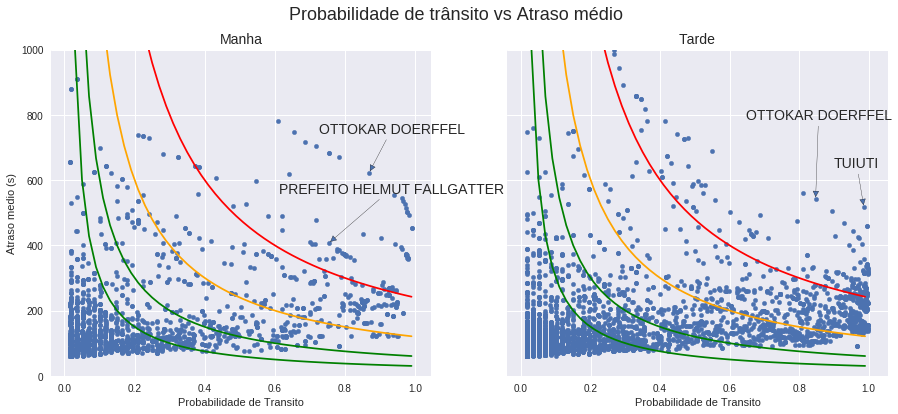

In [3]:
df = gdf.drop("geometry", axis=1)
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(6)
f.set_figwidth(15)

df[df["Período"] == "Manha"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax1)
df[df["Período"] == "Tarde"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax2)

threshold_1 = 30
x = np.arange(0.01, 1.0, 0.02)
y = threshold_1/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

threshold_2 = 60
x = np.arange(0.01, 1.0, 0.02)
y = threshold_2/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

threshold_3 = 120
x = np.arange(0.01, 1.0, 0.02)
y = threshold_3/x
ax1.plot(x,y, color="orange")
ax2.plot(x,y, color="orange")

threshold_4 = 240
x = np.arange(0.01, 1.0, 0.02)
y = threshold_4/x
ax1.plot(x,y, color="red")
ax2.plot(x,y, color="red")

#Annotations - Morning
morning_critical = df[df["Período"] == "Manha"].sort_values("Criticidade", ascending=False).drop_duplicates("Rua")

first_order=0
first_morn_rua = morning_critical["Rua"].iloc[first_order]
first_morn_point = morning_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[first_order]

second_order=2
second_morn_rua = morning_critical["Rua"].iloc[second_order]
second_morn_point = morning_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[second_order]

ax1.annotate(first_morn_rua,
             xy=first_morn_point,
             xytext=(-50, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax1.annotate(second_morn_rua,
             xy=second_morn_point,
             xytext=(-50, 50),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

#Annotations - Afternoon
aftern_critical = df[df["Período"] == "Tarde"].sort_values("Criticidade", ascending=False).drop_duplicates("Rua")

first_order=1
first_aftern_rua = aftern_critical["Rua"].iloc[first_order]
first_aftern_point = aftern_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[first_order]

second_order=2
second_aftern_rua = aftern_critical["Rua"].iloc[second_order]
second_aftern_point = aftern_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[second_order]

ax2.annotate(first_aftern_rua,
             xy=first_aftern_point,
             xytext=(-30, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax2.annotate(second_aftern_rua,
             xy=second_aftern_point,
             xytext=(-70, 80),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)


ax1.set_ylim([0,1000])
ax1.set_title("Manha", fontsize=14)
ax2.set_title("Tarde", fontsize=14)

fig = plt.gcf()
fig.suptitle("Probabilidade de trânsito vs Atraso médio", fontsize=18)

plt.show()

### Classificação Funcional das vias

In [4]:
arteriais = pd.read_csv(project_dir + "/data/external/sepud_vias_arteriais.csv", sep=";")
coletoras = pd.read_csv(project_dir + "/data/external/sepud_vias_coletoras.csv", encoding="Latin-1", sep=";")

arteriais.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)
coletoras.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)

arteriais = arteriais[["nomelog", "tipo_via_"]]
coletoras = coletoras[["nomelog", "tipo_via_"]]

arteriais["ClassFunc score"] = 5
coletoras["ClassFunc score"] = 3

class_func = arteriais.append(coletoras)
class_func.set_index("nomelog", inplace=True)
class_func.rename(columns={"tipo_via_": "ClassFunc"}, inplace=True)

gdf_clf = gdf.join(class_func, on="Rua")
gdf_clf["ClassFunc"].fillna(value="LOCAL/OUTRO", inplace=True)
gdf_clf["ClassFunc score"].fillna(value=1, inplace=True)

#Manual Corrections
gdf_clf.loc[gdf_clf["Rua"] == "OTTO PARUCKER", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["Rua"] == "OTTO PARUCKER", "ClassFunc score"] = 5

gdf_clf.loc[gdf_clf["Rua"] == "CAMBORIU", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["Rua"] == "CAMBORIU", "ClassFunc score"] = 5

print("Amostra:")
gdf_clf[["Codigo do Trecho", "Rua", "ClassFunc", "ClassFunc score"]].head()

Amostra:


,Codigo do Trecho,Rua,ClassFunc,ClassFunc score
0,8322,FLORIANOPOLIS,ARTERIAL,5.0
1,13990,FLORIANOPOLIS,ARTERIAL,5.0
2,5171,FLORIANOPOLIS,ARTERIAL,5.0
3,11432,NOVE DE MARCO,COLETORA,3.0
4,14047,OTTOKAR DOERFFEL,ARTERIAL,5.0


### Acidentes 2015

In [5]:
#Load GeoSections
if 'geo_sections' not in globals():
    meta = connect_database()
    geo_sections = extract_geo_sections(meta, buffer=15)

#Read acidentes and convert it into GeoDataFrame
accidents = pd.read_csv(project_dir + "/data/external/bombeiros_acidentes2015.csv")
accidents["geometry"] = accidents.apply(
                                    lambda row: Point(row["X"], row["Y"]), axis=1)
crs = "+proj=utm +zone=22J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
geo_accidents = gpd.GeoDataFrame(accidents, crs=crs, geometry="geometry")
geo_accidents = geo_accidents.to_crs({'init': 'epsg:4326'})
geo_accidents = gpd.sjoin(geo_accidents, geo_sections, how="left", op="within")

accidents_per_section = geo_accidents.groupby("SctnId").agg({'id': 'count'})
accidents_per_section.rename(columns={"id": "Numero de Acidentes 2015"}, inplace=True)
accidents_per_section.index = accidents_per_section.index.astype(int)
accidents_per_section.sort_values('Numero de Acidentes 2015', ascending=False, inplace=True)

gdf_acc = gdf_clf.join(accidents_per_section, on="Codigo do Trecho")
gdf_acc["Numero de Acidentes 2015"].fillna(value=0, inplace=True)

print("Amostra:")
gdf_acc[["Codigo do Trecho", "Rua", "Numero de Acidentes 2015"]].head()

Amostra:


,Codigo do Trecho,Rua,Numero de Acidentes 2015
0,8322,FLORIANOPOLIS,3.0
1,13990,FLORIANOPOLIS,3.0
2,5171,FLORIANOPOLIS,1.0
3,11432,NOVE DE MARCO,0.0
4,14047,OTTOKAR DOERFFEL,1.0


### Metodologia de Rankeamento

In [7]:
gdf_acc["Transito score"] = pd.cut(gdf_acc["Criticidade"],
                                   bins=[0, threshold_1,threshold_2,threshold_3,threshold_4, 5*threshold_4],
                                   labels=[1,2,3,4,5], retbins=True)[0].astype(int)*2
gdf_acc["Acidentes score"] = pd.cut(gdf_acc["Numero de Acidentes 2015"], bins=5, labels=[1,2,3,4,5], retbins=True)[0].astype(int)
gdf_acc["Total score"] = gdf_acc["Transito score"] + gdf_acc["ClassFunc score"] + gdf_acc["Acidentes score"]

gdf_acc.sort_values(["Total score", "Probabilidade de Transito"], ascending=False, inplace=True)
gdf_ruas = gdf_acc.drop_duplicates("Rua")
col_list = ["Codigo do Trecho", "Rua", "Sentido L/O", "Sentido N/S",
            "Período", "Probabilidade de Transito", "Velocidade Media (km/h)",
            "Fila media (m)", "Atraso medio (s)", "ClassFunc", "Numero de Acidentes 2015",
            "Transito score", "ClassFunc score", "Acidentes score", "Total score"        
           ]
print("As 10 ruas mais críticas de Joinville:")
gdf_ruas[col_list].head(10)

As 10 ruas mais críticas de Joinville:


,Codigo do Trecho,Rua,Sentido L/O,Sentido N/S,Período,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),ClassFunc,Numero de Acidentes 2015,Transito score,ClassFunc score,Acidentes score,Total score
21,8839,TUIUTI,Leste,Sul,Tarde,0.996497,5.991518,709.107143,458.808036,ARTERIAL,9.0,10,5.0,5,20.0
128,4919,FLORIANOPOLIS,Leste,Sul,Tarde,0.981665,15.898353,1611.670588,250.717647,ARTERIAL,7.0,10,5.0,4,19.0
411,2909,GUANABARA,Oeste,Sul,Manha,0.906457,11.163943,966.962862,277.140910,ARTERIAL,8.0,10,5.0,4,19.0
17,7919,OTTOKAR DOERFFEL,Oeste,Sul,Tarde,0.997152,9.978889,1158.444444,329.709402,ARTERIAL,5.0,10,5.0,3,18.0
96,8002,ANITA GARIBALDI,Leste,Norte,Tarde,0.986572,12.442849,1342.826816,258.927374,ARTERIAL,6.0,10,5.0,3,18.0
172,14195,DONA FRANCISCA,Oeste,Norte,Manha,0.974571,9.865956,1128.752390,372.641731,ARTERIAL,6.0,10,5.0,3,18.0
320,843,GETULIO VARGAS,Leste,Sul,Tarde,0.936713,10.359847,1083.183206,265.503817,ARTERIAL,6.0,10,5.0,3,18.0
471,3740,MONSENHOR GERCINO,Leste,Sul,Tarde,0.875260,11.574020,1223.078431,275.862745,ARTERIAL,5.0,10,5.0,3,18.0
736,15890,PREFEITO HELMUT FALLGATTER,Oeste,Sul,Manha,0.765371,14.379861,1742.418780,360.182439,ARTERIAL,6.0,10,5.0,3,18.0
153,9285,QUINZE DE NOVEMBRO,Oeste,Sul,Tarde,0.976555,12.228790,1365.675159,347.458599,ARTERIAL,3.0,10,5.0,2,17.0


In [8]:
map_osm = folium.Map(location=[-26.31739, -48.86499], zoom_start=16, tiles='Stamen Toner')

plot_data = gdf_acc.sort_values("Total score", ascending=False).head(600)

#folium.GeoJson(gdf_acc.sort_values("Total score", ascending=False).head(500)).add_to(map_osm)

map_osm.choropleth(geo_str=plot_data.to_json(),
                   data=plot_data,
                   key_on='feature.properties.{}'.format("Codigo do Trecho"),
                   columns=["Codigo do Trecho", "Criticidade"],
                   fill_color='PuRd', fill_opacity=0.8, line_opacity=1,
                   threshold_scale=[100,200,300,400,500,600])

map_osm

In [9]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clique para mostrar/ocultar código."></form>''')